In [150]:
from compass import *
import stim
import numpy as np
import pymatching as match
import matplotlib.pyplot as plt
import unionfind
import itertools

In [151]:
def bacon_shor_group(dimX, dimZ):
    """
    return the BS code stabilizers
    """
    Xs = []
    Zs = []
    for i in range(dimZ-1):
        s = list('_'*dimZ*dimX)
        for j in range(dimX):
            s[j*dimZ+i] = 'Z'
            s[j*dimZ+i+1] = 'Z'
        Zs.append(''.join(s))
    for i in range(dimX-1):
        s = list('_'*dimX*dimZ)
        for j in range(dimZ):
            s[j+i*dimZ] = 'X'
            s[j+(i+1)*dimZ] = 'X'
        Xs.append(''.join(s))
    return [Xs, Zs]

def bsgauge_group(dimX, dimZ):
    """
    return the gauge group generators for the BS code
    """
    Xs = []
    Zs = []
    # make X-type gauge ops
    for i in range(0, dimZ):
        for j in range(dimX-1):
            s = list('_'*dimX*dimZ)
            s[i+j*dimZ] = 'X'
            s[i+(j+1)*dimZ] = 'X'
            Xs.append(''.join(s))
    # make Z-type gauge ops
    for j in range(dimZ-1):
        for i in range(0, dimX): 
            s = list('_'*dimX*dimZ)
            s[i*dimZ+j] = 'Z'
            s[i*dimZ+j+1] = 'Z'
            Zs.append(''.join(s))
    return [Xs, Zs]

In [152]:
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red ~ -1
    Blue ~ +1
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ['X']*dimX+['_']*dimX*(dimZ-1)
        self.Lz = (['Z']+['_']*(dimX-1))*dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    face_string += ' | '+colored(' # ', 'red')
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    face_string += ' | '+colored(' # ', 'blue')
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Stabilizer dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
            
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[i + k*dimZ] = 'Z'
                gauge[i + k*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimX):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]
        

In [153]:
def pauli2binary(pstr):
    """
    convert pstr to a binary vector
    """
    bstr = [0]*2*len(pstr)
    for idx, c in enumerate(pstr):
        if c == 'X':
            bstr[idx] = 1
        elif c == 'Z':
            bstr[idx+len(pstr)] = 1
        elif c == 'Y':
            bstr[idx] = 1
            bstr[idx+len(pstr)] = 1
    return np.array(bstr)

In [154]:
#union find 
class edgedict(dict):
    def __getitem__(self, key):
        if key in self:
            return super().__getitem__(key)
        return super().__getitem__(tuple(reversed(key)))
    def __setitem__(self, key, value):
        if tuple(reversed(key)) in self:
            return super().__setitem__(tuple(reversed(key)), value)
        else: 
            return super().__setitem__(key, value)
        
### graph data structure
class graph:
    def __init__(self, vertexlist, edgelist):

        self.vertices = vertexlist
        self.edges = edgelist
        self.neighbors = {v: [] for v in self.vertices}
        self.leaves = vertexlist.copy()
        for (u,v) in edgelist:
            if v not in self.neighbors[u]:
                self.neighbors[u].append(v)
                self.neighbors[v].append(u)
                if len(self.neighbors[u]) == 2:
                    self.leaves.remove(u)
                if len(self.neighbors[v]) == 2:
                    self.leaves.remove(v)

    def incident_edges(self, u):
        incident = []
        for v in self.vertices:
            if (u,v) in self.edges: 
                incident.append({u,v})
        return incident

    def find_neighbors(self, u):
        neighbors = []
        for v in self.vertices:
            if (u,v) in self.edges or (v,u) in self.edges: 
                neighbors.append(v)
        return neighbors
    
    def add_vertex(self, u):
        if u not in self.vertices:
            self.vertices.append(u)
            self.neighbors[u] = []
            
    def add_edge(self, e):
        if e not in self.edges:
            (u,v) = e
            if u not in self.vertices:
                self.add_vertex(u)
            if v not in self.vertices:
                self.add_vertex(v)
            self.neighbors[u].append(v)
            self.neighbors[v].append(u)
            if u in self.leaves and len(self.neighbors[u]) > 1:
                self.leaves.remove(u)
            if v in self.leaves and len(self.neighbors[v]) > 1:
                self.leaves.remove(v)
            if u not in self.leaves and len(self.neighbors[u]) == 1:
                self.leaves.append(u)
            if v not in self.leaves and len(self.neighbors[v]) == 1:
                self.leaves.append(v)
            
            self.edges.append(e)
        
    def remove_edge(self, e):
        (u,v) = e
        if len(self.neighbors[u]) == 1:
            self.leaves.remove(u)
        if len(self.neighbors[v]) == 1:
            self.leaves.remove(v)
        if len(self.neighbors[u]) == 2:
            self.leaves.append(u)
        if len(self.neighbors[v]) == 2:
            self.leaves.append(v)    
        self.neighbors[u].remove(v)
        self.neighbors[v].remove(u)
        self.edges.remove(e)

        
def make_decoder_graph(S):
    n = len(S[0])
    vertices = [s for s in S]
    vertices.append('b')
    edges_by_qubit = edgedict({})
    edges = []
    unused_qs = list(range(n))
    for s1, s2 in itertools.combinations(S, 2):
        for q in range(n):
            if s1[q] =='1' and  s2[q]=='1':
                if (s1,s2) not in edges_by_qubit.keys():
                    edges_by_qubit[(s1,s2)] = []
                edges_by_qubit[(s1,s2)].append(q)
                edges.append((s1,s2))
                if q in unused_qs:
                    unused_qs.remove(q)
    for q in unused_qs:
        for s1 in S:
            if s1[q]=='1':
                if (s1,'b') not in edges_by_qubit.keys():
                    edges_by_qubit[(s1,'b')] = []
                edges_by_qubit[(s1,'b')].append(q)
                edges.append((s1,'b'))
    return((graph(vertices, edges), edges_by_qubit))

def construct_modified_erasure(decoder_graph, syn, erasure):
    #1: initialize clusers, support list, boundary lists
    syndrome=syn.copy()
    syndrome['b'] = sum(syndrome.values()) % 2

    #print(syndrome)
    clusters = unionfind.UnionFind(decoder_graph.vertices) #I'm assuming the initial erasure is empty here
    support = edgedict({e: 1 if e in erasure else 0 for e in decoder_graph.edges})
    boundaries = {s: [s] for s in decoder_graph.vertices}
    
    #2: list all clusters with an odd number of marked vertices
    L = [clusters[clusters.find(list(v)[0])] for v in clusters.components() if sum(syndrome[i] for i in v) % 2 == 1]

    #3 while there are odd clusters 
    #This refers to the number of *marked* vertices being odd
    while L != []:
        #print("current L:", L)
        #4: initialize empty fusion list
        fusion = []
        #5 for all u in L, grow the cluster by half an edge
        for u in L:
            #grow the cluster
            root_u = clusters[clusters.find(u)]
            for b in boundaries[root_u]:
                #print("neighbors:", decoder_graph.neighbors[b])
                for n in decoder_graph.neighbors[b]:
                    #grow each edge from the boundary by 0.5
                    if support[(b,n)] < 1:
                        support[(b, n)] += 0.5
                        #add new edges to fusion list
                        if support[(b,n)] == 1:
                            fusion.append((b,n))
            #print('support: ', support)
        #6: for all edges in fusion list, union the clusters if needed
        #print('fusion:', fusion)
        for edge in fusion:
            #print(edge)
            u = edge[0]
            v = edge[1]
            if u not in clusters._elts:
                clusters.add(u)
                boundaries[u] = [u]
            if v not in clusters._elts:
                clusters.add(v)
                boundaries[v] = [v]
            #print(clusters.component(u))
            #print(clusters.component(v))
            #print(clusters.connected(u,v))
            if not clusters.connected(u,v):
                #7 for all edges in fusion list, update the boundary lists
                root_u = clusters[clusters.find(u)]
                root_v = clusters[clusters.find(v)]
                if len(clusters.component(root_u)) > len(clusters.component(root_v)):
                #append boundary list of v to boundary list of u
                #later we will update boundary lists to remove anything that isn't on the boundary anymore
                    boundaries[root_u].extend(boundaries[root_v])
                else:
                #append boundary list of u to boundary list of v
                    boundaries[root_v].extend(boundaries[root_u])
                clusters.union(u,v)
        fusion = []

        #8 replace each u in L with find(u) (new root)
        Lnew = []
        for u in L:
            #print('component:', clusters.component(u))
            #print('syndrome sum: ', sum(syndrome[i] for i in clusters.component(u)))
            if sum(syndrome[i] for i in clusters.component(u)) % 2 == 1: #this checks the number of -1 syndromes (marked vertices) in a cluster
                u_new = clusters[clusters.find(u)]
                if u_new not in Lnew:
                    Lnew.append(u_new)
                    ####9: remove vertices in boundary list of u that are not boundary vertices
                    for v in boundaries[u_new]:
                        #if all edges have support 1 (and there's at least one edge, remove from boundary
                        if len(decoder_graph.incident_edges(v)) > 0:
                            if all(support[tuple(s)]==1 for s in decoder_graph.incident_edges(v)): boundaries[u_new].remove(v)


        L = Lnew
        #10 remove even components from the list of components to grow
        if len(clusters.component(u)) % 2 == 0 and u in L:
            L.remove(u)
    #11 add edges to the modified erasure
    for edge in support.keys():
        if support[edge] == 1: #fully-grown edge
            erasure.append(edge)
    
    #result at this point is a list of edges making up the modified erasure
    return erasure

####12 apply peeling decoder to the erasure
def peeling_decoder(erasure, edges_to_qubits, num_qs, decoder_graph, syn):
    syndrome=syn.copy()
    syndrome['b'] = sum(syndrome.values()) % 2
    
    if len(erasure) == 0:
        correction = ''
    else:
        erasure_vertices = set(list(zip(*erasure))[0])
        erasure_vertices.update(set(list(zip(*erasure))[1]))
        erasure_vertices = list(erasure_vertices)
        #1: construct spanning forest of erasure
        erasure_graph = graph(erasure_vertices, erasure)
        erasure_forest = graph([],[]) #need vertex list for modified erasure
        r = erasure_vertices[0] #pick a root
        remaining_vertices = erasure_vertices
        visited = set()
        queue = []
        
        #erasure forest should not have isolated vertices
        #we should remove vertices that have no neighbors or not call them leaves

        while remaining_vertices: 
            #find a connected component
            queue.append(remaining_vertices.pop(0))
            while queue:
                u = queue.pop(0)
                #print(u)
                if u not in visited:
                    erasure_forest.add_vertex(u)
                    visited.add(u)
                    neighbors = erasure_graph.neighbors[u]
                    #print('neighbors', neighbors)
                    for v in neighbors:
                        if v in remaining_vertices:
                            erasure_forest.add_edge({u,v}) #modify add_edge to do this automatically
                            queue.append(v)
                            remaining_vertices.remove(v)
                
            

        #print('erasure forest:', erasure_forest.edges)
        #2 initialize A
        #print(erasure_forest.edges)
        A = []
        #3: while the forest is nonempty
        while erasure_forest.edges != []:
            #pick a leaf and remove e, with pendant vertex u
            #get vertices, id pendant vertex
            u = erasure_forest.leaves[0]
            v = erasure_forest.neighbors[u][0]
            e = {u,v}
            erasure_forest.remove_edge(e) #need something that updates the leaves when removing edges
            #4: if u is in the syndrome, add e to A, remove u from syndrome, and flip v in syndrome
            if syndrome[u]==1:
                A.append(edges_to_qubits[(u,v)][0])
                syndrome[u]=1
                if syndrome[v]==1:
                    syndrome[v]=0
                else:
                    syndrome[v]=1   
        P = str()
        correction = [0 for i in range(num_qs)]
        for e in A:
            P += 'Z'+str(e)
            correction[e] = 1
    return correction


---

0) Make Tableau
1) Sample error
2) Find syndrome
3) Decode
4) Check if correction operation commutes with stabs

https://github.com/quantumlib/Stim

In [155]:
class StimWrapper():
    def __init__(self, lattice):
        self.lat = lattice
        self.stabs = []
        for s in lattice.getS():
            self.stabs.append(stim.PauliString(s))
    def syndrome(self, error):
        syn = []
        for s in self.stabs:
            if s.commutes(stim.PauliString(error)):
                syn.append(0)
            else:
                syn.append(1)
        return syn
    def logical_check(self, pauli):
        if ( pauli.commutes(stim.PauliString(''.join(self.lat.Lx))) and 
            pauli.commutes(stim.PauliString(''.join(self.lat.Lz)))):
            return True
        else: 
            return False
    def test(self, hist):
        
        # setup MWPM decoder
        Sx = self.lat.getSx()
        Sz = self.lat.getSz()
        Hx = [''.join(['1' if i != '_' else '0' for i in s]) for s in Sx]
        Hz = [''.join(['1' if i != '_' else '0' for i in s]) for s in Sz]
        #Mx = Matching(Hx)
        #Mz = Matching(Hz)
        
        r_failure = 0
        
        for error in hist.keys():
            #print(error)
            num_qs = len(Sx[0])
            syn = self.syndrome(error)
            #syndromes
            syndrome_x = {Hx[i]: syn[i] for i in range(len(syn[:len(Sx)]))}
            syndrome_z = {Hz[i]: syn[len(Sx)+i] for i in range(len(syn[len(Sx):]))}
            decoder_graph_x, edges_by_qubit =make_decoder_graph(Hx)
            #print('edges: ', edges_by_qubit)
            #print('decoder graph:', decoder_graph_x.neighbors)
            #decoder_graph = graph(vertices, edges)
            #print('syn x:', syndrome_x)
            new_erasure_x =construct_modified_erasure(decoder_graph_x, syndrome_x, [])
            #print(syndrome_x)
            #print(new_erasure_x)
            cz = peeling_decoder(new_erasure_x, edges_by_qubit, num_qs, decoder_graph_x, syndrome_x)
            
            #print('syn z:', syndrome_z)
            decoder_graph_z, edges_by_qubit =make_decoder_graph(Hz)
            #print('edges: ', edges_by_qubit)
            #print('decoder graph:', decoder_graph_z.neighbors)
            #decoder_graph = graph(vertexlist, edgelist)
            new_erasure_z =construct_modified_erasure(decoder_graph_z, syndrome_z, [])
            #print(syndrome_z)
            #print(new_erasure_z)
            cx = peeling_decoder(new_erasure_z, edges_by_qubit, num_qs, decoder_graph_z, syndrome_z)

            Rx = stim.PauliString(''.join(['X' if i == 1 else '_' for i in cx]))
            Rz = stim.PauliString(''.join(['Z' if i == 1 else '_' for i in cz]))
            recovery = Rx*Rz
            corrected = recovery*stim.PauliString(error)
            if self.logical_check(corrected) is False:
                r_failure += hist[error]
        return r_failure

In [156]:
N = 10**4
lat = Lattice2D(6,7)
slat = StimWrapper(lat)
hist = sample_globalbias(25, 0.0001, 0.001, 0.001, N)
slat.test(hist)

0.011399999999999997

---

# landscape exploration

In [157]:
def str2color(string):
    RGB = np.array([0., 0., 0.])
    for idx, c in enumerate(string):
        if c == -1:
            RGB += (1/2**(idx+1))*np.array([1, 0, 0])
        elif c == 1:
            RGB += (1/2**(idx+1))*np.array([0, 0, 1])
        elif c == 0:
            RGB += (1/2**(idx+1))*np.array([1, 1, 1])
    return RGB

0.0 0.0
0.0011111111111111111 0.0
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.0011111111111111111 0.0011111111111111111
lattice 0
lattice 1
lattice 2
lattice 3
l

lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.0011111111111111111 0.01
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
latt

lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.0022222222222222222 0.008888888888888889
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72

lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.003333333333333333 0.0077777777777777776
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66

lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.0044444444444444444 0.006666666666666666
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59

lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.005555555555555556 0.005555555555555556
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56


lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.006666666666666666 0.0044444444444444444
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50

lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.0077777777777777776 0.003333333333333333
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46

lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.008888888888888889 0.0022222222222222222
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38

lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80
0.01 0.0011111111111111111
lattice 0
lattice 1
lattice 2
lattice 3
lattice 4
lattice 5
lattice 6
lattice 7
lattice 8
lattice 9
lattice 10
lattice 11
lattice 12
lattice 13
lattice 14
lattice 15
lattice 16
lattice 17
lattice 18
lattice 19
lattice 20
lattice 21
lattice 22
lattice 23
lattice 24
lattice 25
lattice 26
lattice 27
lattice 28
lattice 29
lattice 30
lattice 31
lattice 32
lattice 33
lattice 34
lattice 35
lattice 36
lattice 37
lattice 38
lattice 39
lattice 40
lattice 41
lattice 42
lattice 43
latt

lattice 40
lattice 41
lattice 42
lattice 43
lattice 44
lattice 45
lattice 46
lattice 47
lattice 48
lattice 49
lattice 50
lattice 51
lattice 52
lattice 53
lattice 54
lattice 55
lattice 56
lattice 57
lattice 58
lattice 59
lattice 60
lattice 61
lattice 62
lattice 63
lattice 64
lattice 65
lattice 66
lattice 67
lattice 68
lattice 69
lattice 70
lattice 71
lattice 72
lattice 73
lattice 74
lattice 75
lattice 76
lattice 77
lattice 78
lattice 79
lattice 80


<function matplotlib.pyplot.show(*args, **kw)>

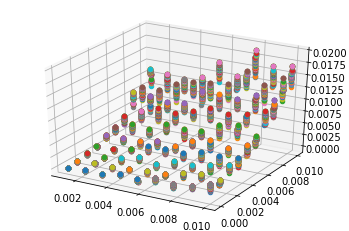

In [158]:
N = 10**4
dim = 3
color_set = [i for i in itt.product([-1, 0, 1], repeat=(dim-1)**2)]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lattices = []
for c in color_set:
    lat = Lattice2D(dim,dim)
    lat.color_lattice(c)
    lattices.append(StimWrapper(lat))
    
    
for p in np.linspace(0.0, 0.01, 10):
    for q in np.linspace(0.0, 0.01, 10):
        print(p,q)
        if p == 0 and q == 0: 
            break
        hist = sample_globalbias(dim**2, q, q, p, N)
        i = 0
        for lat in lattices:
            print('lattice {}'.format(i))
            i+=1
            r_failure = lat.test(hist)
            ax.scatter(p, q, r_failure)
plt.show